In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#sns.get_dataset_names()

In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()
flight_data.shape

(144, 3)

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

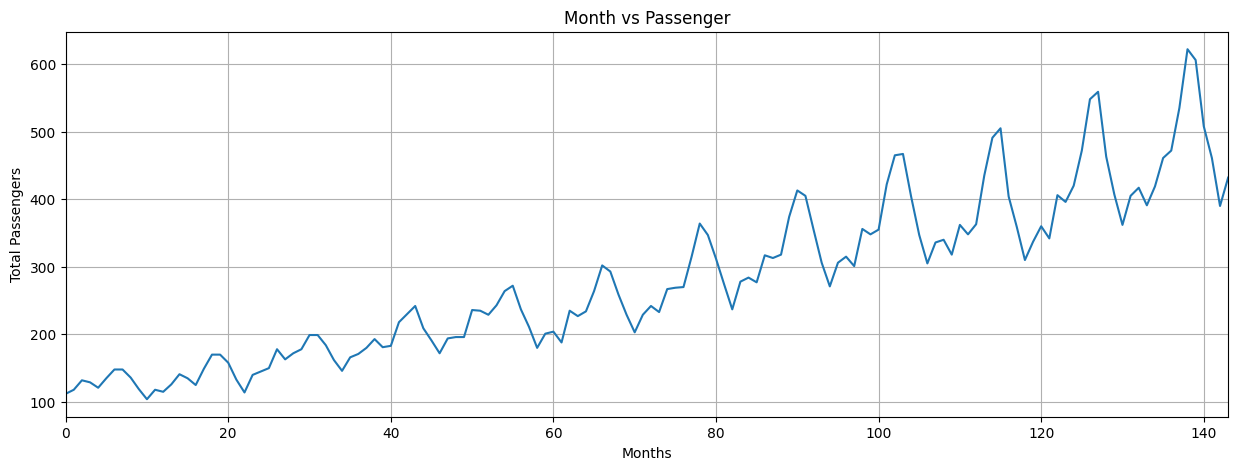

In [5]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [6]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [7]:
all_data = flight_data['passengers'].values.astype(float)

In [8]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [9]:
print(len(train_data))
print(len(test_data))

132
12


In [10]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [12]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [13]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([132])

In [14]:
train_window = 12

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
len(train_inout_seq)

120

In [17]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [18]:
torch.zeros(1,1,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [19]:
seq, label = train_inout_seq[0]
seq

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])

In [20]:
seq.shape

torch.Size([12])

In [21]:
a=seq.view(len(seq), 1 , -1)  #-1 so that number of elements in view matches the original number of elements

In [22]:
b=torch.reshape(seq, (len(seq), 1,1 ))

In [23]:
hidden_cell = (torch.zeros(1,1,5),
                            torch.zeros(1,1,5))
hidden_cell

(tensor([[[0., 0., 0., 0., 0.]]]), tensor([[[0., 0., 0., 0., 0.]]]))

In [66]:
class LSTM(nn.Module):
    #HIDDEN LAYER SIZE WAS 100 initially
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.arr_sd =[]

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        std_lstm = torch.std(lstm_out)
        #print ("LSTM: ",  std_lstm.item())
        #lstm_out = lstm_out[:, -1] # convert to 2D -- same as #lstm_out_reshaped = lstm_out.view(len(input_seq), -1)  
       #print ("LSTM: ", lstm_out.shape)
       # print ("Hidden: ",self.hidden_cell)
        #  print ("RESHAPED: ", lstm_out_reshaped[-1])
       # arr= lstm_out_reshaped.detach().numpy()
        #print(arr)
        #print()
       # sd = torch.std(lstm_out_reshaped)
        #arr_sd.append(sd)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        #print ("Predictions: ", predictions)
        #print ("Predictions[-1] ",predictions[-1])
     
        #return predictions[-1]
        #return lstm_out
        return std_lstm.item()

In [67]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [68]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


[0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242]


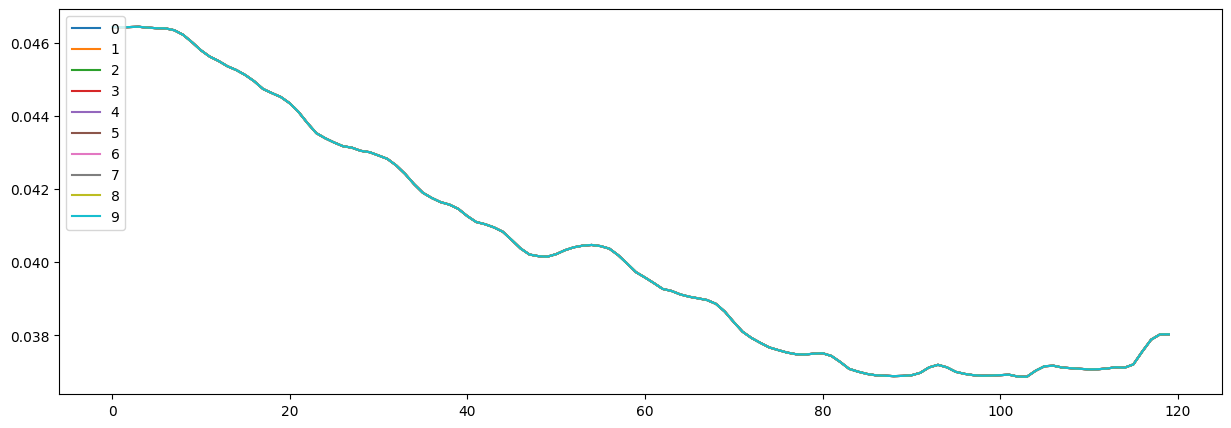

In [86]:
epochs =10
loss=[]
epoch=[]

std_lstm_epoch =[]

t= torch.zeros(12,1,5)
for i in range(epochs):
    #print ("Epoch  ", i)
    std_lstm_list = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        
        #print(y_pred)
        std_lstm_list.append(y_pred)
        #print("List: ", lstm_out_list)
        #single_loss = loss_function(y_pred, labels) 
        #single_loss.backward()
        #optimizer.step()
    plt.plot( std_lstm_list, label=i)
    plt.legend(loc= "upper left")
    #std_lstm_epoch.append(sum(std_lstm_list)/len(std_lstm_list))
    std_lstm_epoch.append(np.std(std_lstm_list))
    epoch.append(i)
    #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    #print()
    #if i%25 == 1:
    #    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
print(std_lstm_epoch)

plt.show()

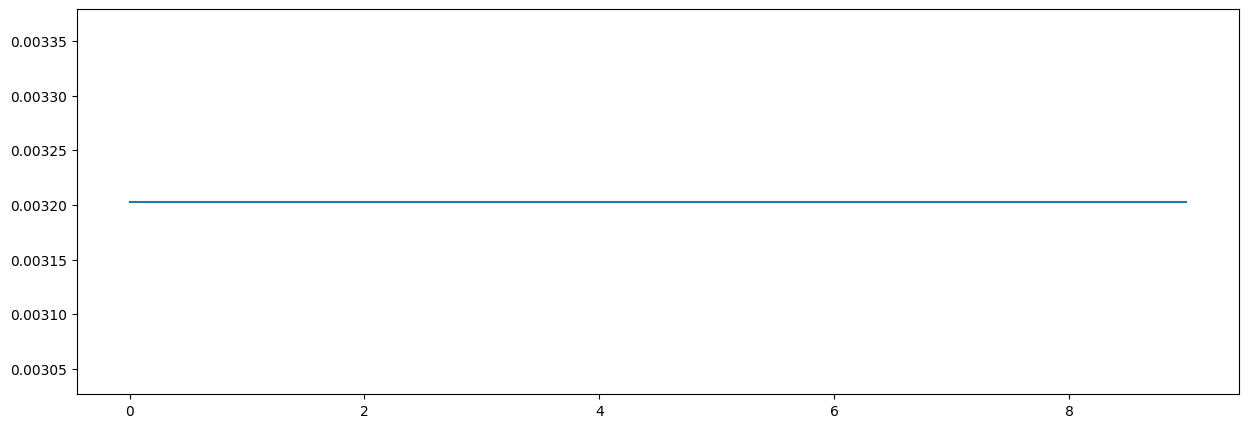

In [87]:
plt.plot(epoch, std_lstm_epoch)

In [73]:
epochs =100
loss=[]
epoch=[]

std_lstm_epoch =[]

t= torch.zeros(12,1,5)
for i in range(epochs):
    #print ("Epoch  ", i)
    std_lstm_list = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        #print(y_pred)
        std_lstm_list.append(y_pred)
        #print("List: ", lstm_out_list)
        #single_loss = loss_function(y_pred, labels) 
        #single_loss.backward()
        #optimizer.step()
    #std_lstm_epoch.append(sum(std_lstm_list)/len(std_lstm_list))
    std_lstm_epoch.append(np.std(std_lstm_list))
    epoch.append(i)
    #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    #print()
    #if i%25 == 1:
    #    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
print(std_lstm_epoch)

[0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.0032028617440074242, 0.00320286

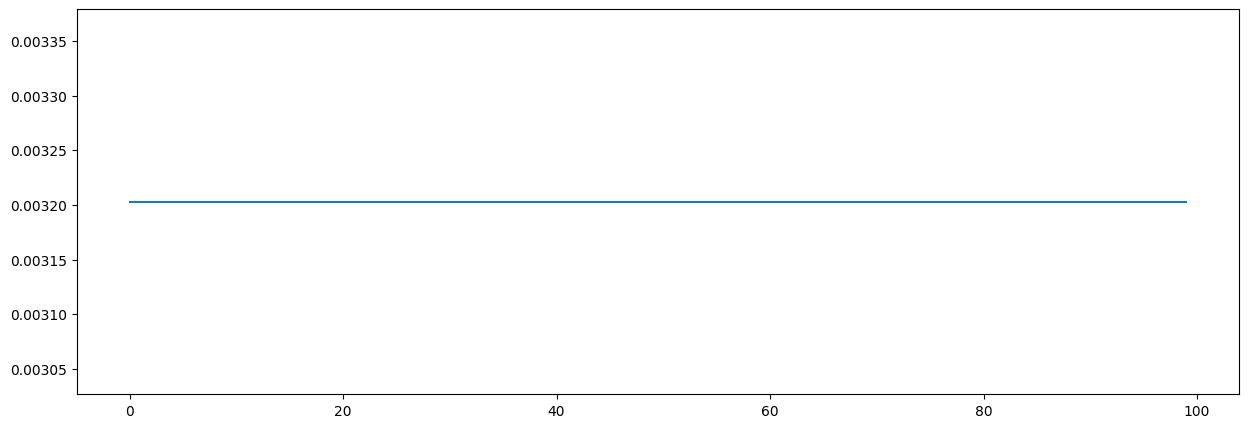

In [74]:
plt.plot(epoch, std_lstm_epoch)

In [ ]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

In [ ]:
model.eval()



In [ ]:
test_inputs

In [ ]:
test_inputs[-train_window:]

In [ ]:
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        #test_inputs.append(model(seq).item())
        test_inputs.append(model(seq))

In [ ]:
test_inputs[fut_pred:]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
x = np.arange(132, 144, 1)
print(x)

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()